# A Datamining Approach to the Anet Database of Hand Printed Books
# The Case of Early Modern Quiring Practices

__[Tom Deneire](https://tomdeneire.github.io/)__

(last revision: 14 November 2020)

## Introduction

This notebook contains a data mining approach to the database of hand printed books, collected by the __[Anet](https://anet.be)__ network of libraries. This database currently contains about 2,500,000 records, 50,000 of which have "od" membership, which means they were catalogued as hand printed books with specialized information regarding impressum, collation, etcetera.

More specifically, this notebook aims to analyse the Early Modern practice of 'quiring' gatherings in handpress book production. Gaskell’s manual on bibliography defines quiring as follows:

>It was normal in the early days of printing to impose (sc. sheets) for gatherings of several sheets tucked, or quired, inside each other. Thus a folio gathering might consist of three folio sheets (i.e. three sheets folded once), the outermost of which contained pages 1 and 12 (printed from the outer forme) and pages 2 and 11 (from the inner forme); the middle sheet had pages 3 and 10, 4 and 9; and the innermost sheet had pages 5 and 8, 6 and 7. All three sheets were signed with the same letter (A1 on page 1, A2 on page 3, and A3 on page 5), and the folding is designated ‘2° in 6s’ 
>
> (Philip Gaskell, A New Introduction to Bibliography. The Classic Manual of Bibliography (Oxford: OUP, 2012: first ed. 1972, second ed. 1995), p. 82)

## Extracting the data
The first step is to extract the necessary data from the Anet database. After selecting all records with membership "od" we then exported those as a `.sqlite` file, which is Anet's preferred file format for their __[open data collections](https://www.uantwerpen.be/nl/projecten/anet/open-data/)__

We then select the necessary information from this SQLite database with the following query, which also performs some data cleaning to remove unusable collation rows (e.g. "16 volumes"). We then save the data from the selection to a __[Pandas](https://pandas.pydata.org/)__ dataframe and display some information from this dataset, such as the total number of remaining entries (24,020) and a sample of the data.

In [92]:
import sqlite3
import pandas as pd
from pandas import DataFrame
conn = sqlite3.connect('od.sqlite')
cur = conn.cursor()
query = """
select distinct 
    collation.cloi, format, collation.collation_ka, impressum.impressum_ju1sv, impressum.impressum_ju2sv, 
    impressum.impressum_pc, impressum.impressum_pl, impressum.impressum_uc, impressum.impressum_ug 
    from collation 
join 
    (select distinct collation.cloi as id, collation.collation_fm as format from collation) on id = collation.cloi 
left join impressum on impressum.cloi = collation.cloi 
where 
    not format='' 
    and not format='-' 
    and not collation.collation_ka='' 
    and not collation.collation_ka like '%#' 
    and not collation.collation_ka like '% volumes'
"""

cur.execute(query)
data = [row for row in cur.fetchall()]
conn.close()
df_collation = pd.DataFrame(data, columns=['identifier', 'format', 'collation', 'year1', 'year2', 'place_code', 'place_name', 'publisher_code', 'publisher_name'])
# Deleting bottom row, which contains original column labels
df_collation = df_collation[:-1]
display(df_collation.info(), df_collation[0:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24020 entries, 0 to 24019
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   identifier      24020 non-null  object
 1   format          24020 non-null  object
 2   collation       24020 non-null  object
 3   year1           24020 non-null  object
 4   year2           24020 non-null  object
 5   place_code      24020 non-null  object
 6   place_name      24020 non-null  object
 7   publisher_code  24020 non-null  object
 8   publisher_name  24020 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


None

,identifier,format,collation,year1,year2,place_code,place_name,publisher_code,publisher_name
0,c:lvd:1000803,octavo,ã<sup>8</sup> A-2X<sup>8</sup> 2Y<sup>6</sup>,1568,,a::91.44.0201:1,Parijs,a::06.5360:1,"Frémy, Claude"
1,c:lvd:1000848,octavo,+<sup>4</sup> A-2F<sup>8</sup> 2G<sup>4</sup>,1564,,a::91.44.10718:1.3,Rheims,a::06.5880:1.6,chez Jean de Foigny
2,c:lvd:1001386,octavo,A-K<sup>8/4</sup>,1756,,a::91.44.0201:1.23,Paris,a::06.8276:1.1,de l'imprimerie de la nobless commerçante
3,c:lvd:1001438,quarto,[A]<sup>2</sup>,1709,,a::91.493.2000:1.15,Antverpiæ,a::06.303:1.9,apud viduam Petri Jacobs
4,c:lvd:1001449,octavo,A<sup>8</sup> B-2P<sup>4</sup>,1775,,a::91.493.2000:1.43,Antwerpen,a::06.223:1.1,by J.B. Carstiaenssens


## Counting gatherings

The next step is to count the number of sheets quired inside each other thus making up the gatherings, e.g. A-F<sup>4</sup> G² contains 6 gatherings of 4 sheets (quire marks A-F) and one of 2 (quire mark G). We also count gatherings with alternating quirings (e.g. 4/2), the multiple usage of quire marks (e.g. A-F<sup>4</sup> ²A-F<sup>4</sup>) and inserted gatherings, registered with π and χ (e.g. A<sup>8</sup> (A5 + <sup>χ</sup>A² B-D<sup>8</sup>). 

We write this dataset to a second dataframe and then offer a sample of it.

In [93]:
import re
alternating_quires = ['<sup>4/2</sup> ', '<sup>4/6</sup> ', '<sup>4/8</sup> ', '<sup>6/8</sup> ', '<sup>8/4</sup> ', '<sup>8/6</sup> ']
inserted_gatherings = ['<sup>π</sup>', '<sup>χ</sup>']
results = []
for collation in df_collation.iloc[:,2]:
    # add whitespace to final gathering
    # gatherings counted with '</sup> ', i.e. with added whitespace, to avoid counting doubles etc. (e.g. <sup>2</sup>A)
    collation = str(collation) + ' ' 
    gatherings = []
    # normal quires
    normal_quires = [f'<sup>{str(i)}</sup> ' for i in range(2,22,2)]
    for normal in normal_quires:                                      
        if normal in collation:
            gatherings.append(1)
        else:
            gatherings.append(0)
    # alternating quires
    for alternate in alternating_quires:
        if alternate in collation:
            gatherings.append(1)
        else:
            gatherings.append(0)            
    # multiple quire marks
    multiple_quires = [re.compile('<sup>' + str(i) + '</sup>\S') for i in range(2,8,2)]
    for multiple in multiple_quires:
        if multiple.search(collation):
            gatherings.append(1)
        else:
            gatherings.append(0) 
    # inserted gatherings
    for inserted in inserted_gatherings:
        if inserted in collation:
            gatherings.append(1)
        else:
            gatherings.append(0)  
    results.append(gatherings)
columns_quires = [
    '2', '4', '6', '8', '10', '12', '14', '16', '18', 
    '20', '4/2', '4/6', '4/8', '6/8', '8/4', '8/6', 
    'double', 'quadruple', 'sextuple', 'pi', 'chi']
columns_types = {column: 'int' for column in columns_quires}
df_collation_count = pd.DataFrame(results, columns=columns_quires)
display(df_collation_count[0:5])

,2,4,6,8,10,12,14,16,18,20,...,4/6,4/8,6/8,8/4,8/6,double,quadruple,sextuple,pi,chi
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can then combine both dataframes in a third dataframe which will be the working dataset for the analysis. We also export it to .csv for future reference.

In [94]:
df = pd.concat([df_collation, df_collation_count], axis=1, sort=False)
display(df[0:5])
df.to_csv('dataset.csv')

,identifier,format,collation,year1,year2,place_code,place_name,publisher_code,publisher_name,2,...,4/6,4/8,6/8,8/4,8/6,double,quadruple,sextuple,pi,chi
0,c:lvd:1000803,octavo,ã<sup>8</sup> A-2X<sup>8</sup> 2Y<sup>6</sup>,1568,,a::91.44.0201:1,Parijs,a::06.5360:1,"Frémy, Claude",0,...,0,0,0,0,0,0,0,0,0,0
1,c:lvd:1000848,octavo,+<sup>4</sup> A-2F<sup>8</sup> 2G<sup>4</sup>,1564,,a::91.44.10718:1.3,Rheims,a::06.5880:1.6,chez Jean de Foigny,0,...,0,0,0,0,0,0,0,0,0,0
2,c:lvd:1001386,octavo,A-K<sup>8/4</sup>,1756,,a::91.44.0201:1.23,Paris,a::06.8276:1.1,de l'imprimerie de la nobless commerçante,0,...,0,0,0,1,0,0,0,0,0,0
3,c:lvd:1001438,quarto,[A]<sup>2</sup>,1709,,a::91.493.2000:1.15,Antverpiæ,a::06.303:1.9,apud viduam Petri Jacobs,1,...,0,0,0,0,0,0,0,0,0,0
4,c:lvd:1001449,octavo,A<sup>8</sup> B-2P<sup>4</sup>,1775,,a::91.493.2000:1.43,Antwerpen,a::06.223:1.1,by J.B. Carstiaenssens,0,...,0,0,0,0,0,0,0,0,0,0


## Analysing and visualizing gatherings

After collecting the data and counting the gatherings, we can now analyse and visualize the results of this operation. 

First, we make a sum of all quiring practices (quires of ones, twos, threes, ...) and plot the result. (Here, and in future dataframes, columns with a value of `0` are dropped from the table and figure)

,2,4,6,8,10,12,14,16,18,20,...,4/6,4/8,6/8,8/4,8/6,double,quadruple,sextuple,pi,chi
0,5949,11728,4683,10037,496,2880,19,62,3,2,...,6,18,12,409,18,1108,259,142,143,59


<AxesSubplot:title={'center':'General'}>

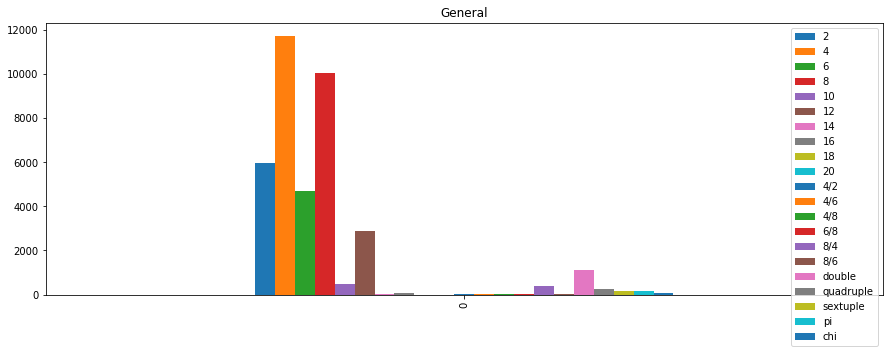

In [95]:
def sum_and_dropzero(base_df: DataFrame, columns_list: list) -> DataFrame:
    new_df = pd.DataFrame(columns=columns_list)
    new_df.loc[0] = [base_df[column].sum() for column in columns_list]
    new_df = new_df.loc[:, (new_df != 0).any(axis=0)]
    return new_df

df_general = sum_and_dropzero(df, columns_quires)
display(df_general)
df_general.plot(kind='bar', title='General', figsize=(15,5))

Or, we can also select a certain bibliographic format, e.g. `quarto`, to see how this compares to quiring practices in general. 

,2,4,6,8,10,12,14,16,20,4/6,4/8,8/4,8/6,double,quadruple,sextuple,pi,chi
0,2206,5058,667,681,71,8,3,1,1,2,3,6,4,256,110,28,30,9


<AxesSubplot:title={'center':'Quarto'}>

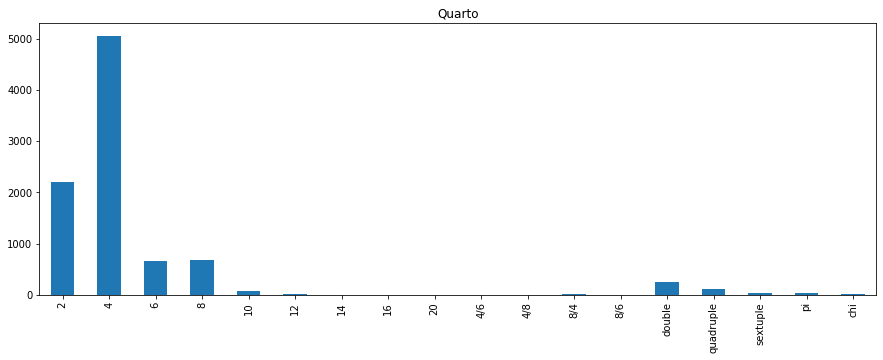

In [96]:
df4 = df.loc[df['format'] == 'quarto']
df_quarto = sum_and_dropzero(df4, columns_quires)
display(df_quarto)
df_quarto.iloc[0].plot(kind='bar', title='Quarto', figsize=(15,5))

Or, we could have a look at sixteenth-century quiring practices.

,2,4,6,8,10,12,14,16,4/6,4/8,6/8,8/4,8/6,double,quadruple,sextuple,pi,chi
0,499,2894,1070,3237,148,149,1,1,4,3,3,17,6,207,59,51,66,3


<AxesSubplot:title={'center':'Sixteenth'}>

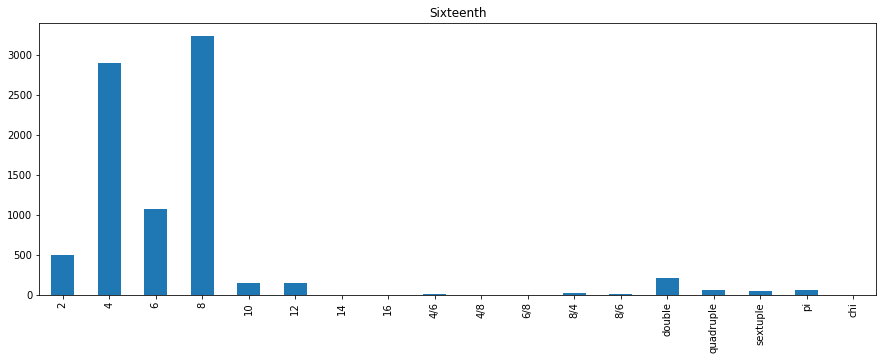

In [97]:
df_16 = df.loc[pd.to_numeric(df['year1']).isin(range(1500,1600))]
df_sixteen = sum_and_dropzero(df_16, columns_quires)
display(df_sixteen)
df_sixteen.iloc[0].plot(kind='bar', title='Sixteenth', figsize=(15,5))

Or, sixteenth-century quartos in particular.

,2,4,6,8,10,12,14,4/6,4/8,8/4,8/6,double,quadruple,sextuple,pi,chi
0,294,1295,246,197,20,1,1,1,2,6,3,39,34,10,11,1


<AxesSubplot:title={'center':'16-c. quarto'}>

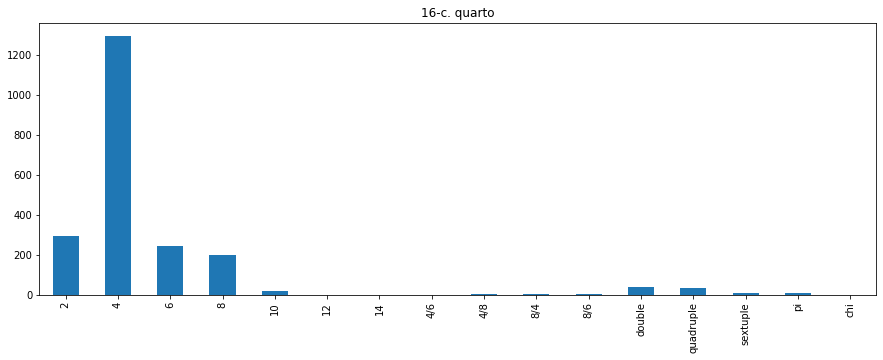

In [98]:
df_16 = df.loc[pd.to_numeric(df['year1']).isin(range(1500,1600))]
df_16_quarto = df_16.loc[df_16['format'] == 'quarto']
df_sixteenthc_quarto = sum_and_dropzero(df_16_quarto, columns_quires)
display(df_sixteenthc_quarto)
df_sixteenthc_quarto.iloc[0].plot(kind='bar', title='16-c. quarto', figsize=(15,5))

Or, all sixteenth-century quartos printed in Antwerp.

,2,4,6,8,10,12,double,quadruple,pi
0,114,573,100,79,8,1,9,22,3


<AxesSubplot:title={'center':'16-c. quarto Antwerp'}>

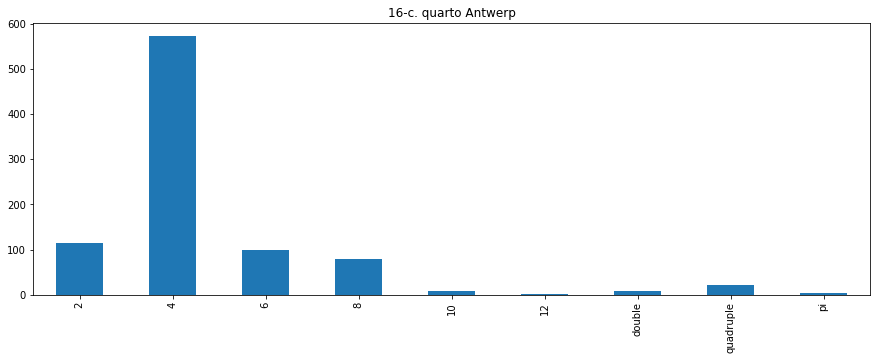

In [99]:
df_16 = df.loc[pd.to_numeric(df['year1']).isin(range(1500,1600))]
df_16_quarto = df_16.loc[df_16['format'] == 'quarto']
df_16_quarto_Antwerp = df_16_quarto.loc[df_16['place_code'].str.startswith('a::91.493.2000')]
df_sixteenthc_quarto_Antwerp = sum_and_dropzero(df_16_quarto_Antwerp, columns_quires)
display(df_sixteenthc_quarto_Antwerp)
df_sixteenthc_quarto_Antwerp.iloc[0].plot(kind='bar', title='16-c. quarto Antwerp', figsize=(15,5))

Finally, we can use stacked bars to plot some graphs that allow to compare quiring practices over different formats and different centuries. We also save these dataframes to .csv files for future reference.

,2,4,6,8,10,12,14,16,18,20,...,4/6,4/8,6/8,8/4,8/6,double,quadruple,sextuple,pi,chi
plano,6,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
folio,880,1505,1585,845,141,20,3,1,0,0,...,3,0,12,0,14,392,67,80,58,29
quarto,2206,5058,667,681,71,8,3,1,0,1,...,2,3,0,6,4,256,110,28,30,9
octavo,1770,3957,848,6940,121,70,3,26,1,1,...,0,0,0,18,0,311,67,13,41,16
duodecimo,1035,1030,1472,771,159,2701,9,3,1,0,...,1,13,0,373,0,126,13,18,8,5
sextodecimo,17,90,32,537,1,13,1,29,1,0,...,0,2,0,4,0,13,0,0,6,0
octodecimo,17,18,41,11,0,13,0,0,0,0,...,0,0,0,1,0,4,1,3,0,0
vicesimoquarto,15,68,36,226,1,53,0,1,0,0,...,0,0,0,7,0,4,0,0,0,0
tricesimosecundo,3,1,2,24,0,2,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


<AxesSubplot:title={'center':'Format vs quiring'}>

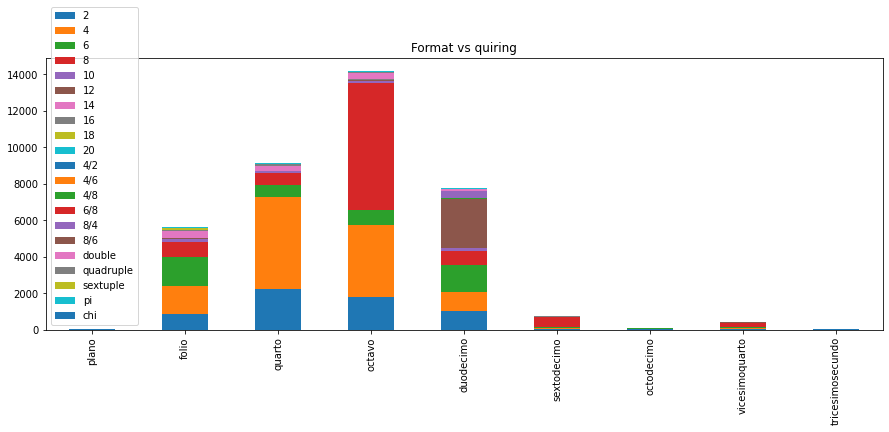

In [100]:
sum_all = []
formats = ['plano', 'folio', 'quarto', 'octavo', 'duodecimo', 'sextodecimo', 'octodecimo', 'vicesimoquarto', 'tricesimosecundo']
for form in formats:
    df_new = df.loc[df['format'] == form]
    sum_all.append([df_new[column].sum() for column in columns_quires])
df_formats = pd.DataFrame(sum_all, columns=columns_quires, index=formats)
display(df_formats)
df_formats.to_csv('formats.csv')

df_formats.plot(kind='bar', stacked='True', title='Format vs quiring', legend=True, figsize=(15,5))

,2,4,6,8,10,12,14,16,18,20,...,4/6,4/8,6/8,8/4,8/6,double,quadruple,sextuple,pi,chi
0,4,58,121,161,57,15,1,0,0,0,...,1,1,9,0,12,11,0,2,4,0
1,489,2842,1046,3198,143,143,1,1,0,0,...,4,3,3,17,6,202,57,48,66,3
2,1703,4535,1797,2901,126,1386,6,20,1,0,...,0,5,0,145,0,424,115,59,46,38
3,3267,3671,1395,3116,149,1160,10,35,2,2,...,1,7,0,232,0,414,79,22,25,15


<AxesSubplot:title={'center':'15th, 16th, 17th, 18th century vs quiring practices'}>

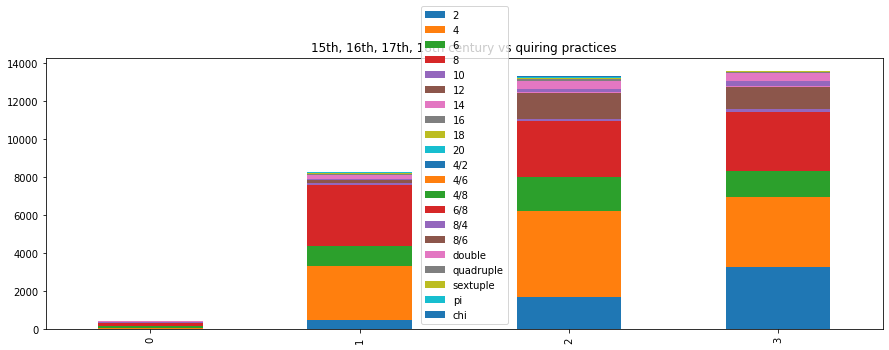

In [101]:
sum_all = []
centuries = [range(1400,1499), range(1500,1599), range(1600,1699), range(1700,1799)]
for century in centuries:
    df_century = df.loc[pd.to_numeric(df['year1']).isin(century)]
    sum_all.append([df_century[column].sum() for column in columns_quires])
df_centuries = pd.DataFrame(sum_all, columns=columns_quires)
display(df_centuries)
df_centuries.to_csv('centuries.csv')
df_centuries.plot(kind='bar', stacked='True', title='15th, 16th, 17th, 18th century vs quiring practices', legend=True, figsize=(15,5))

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
15th-c folio,4,22,70,92,43,13,1,0,0,0,...,0,0,9,0,11,7,0,2,3,0
16th-c folio,89,446,627,376,63,4,0,0,0,0,...,3,0,3,0,3,90,11,34,29,1
17th-c folio,294,672,707,304,25,2,1,1,0,0,...,0,0,0,0,0,169,35,37,16,24
18th-c folio,468,325,147,55,5,1,1,0,0,0,...,0,0,0,0,0,111,19,4,8,4
15th-c quarto,0,27,46,52,10,1,0,0,0,0,...,1,1,0,0,1,4,0,0,1,0
16th-c quarto,289,1265,241,195,20,1,1,0,0,0,...,1,2,0,6,3,39,32,10,11,1
17th-c quarto,836,2389,271,158,18,1,1,0,0,0,...,0,0,0,0,0,105,50,15,16,5
18th-c quarto,999,1227,85,247,23,4,1,1,0,1,...,0,0,0,0,0,104,26,3,2,2
15th-c octavo,0,9,5,17,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16th-c octavo,89,1021,108,2082,58,5,0,0,0,0,...,0,0,0,0,0,56,13,3,19,1


<AxesSubplot:title={'center':'15th, 16th, 17th, 18th folios, quartos, octavos and duodecimos'}>

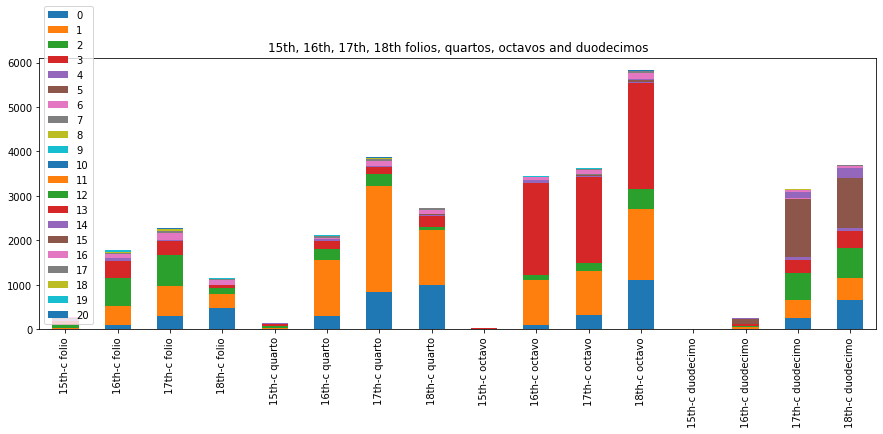

In [102]:
sum_all = []
formats = ['folio', 'quarto', 'octavo', 'duodecimo']
centuries = [range(1400,1499), range(1500,1599), range(1600,1699), range(1700,1799)]
for form in formats:
    df_century = df.loc[df['format'] == form]
    for century in centuries:
        df_century_format = df_century.loc[pd.to_numeric(df_century['year1']).isin(century)]      
        sum_all.append([df_century_format[column].sum() for column in columns_quires])

indices = ['15th-c folio', '16th-c folio', '17th-c folio', '18th-c folio', '15th-c quarto', '16th-c quarto', '17th-c quarto', '18th-c quarto', '15th-c octavo', '16th-c octavo', '17th-c octavo', '18th-c octavo', '15th-c duodecimo', '16th-c duodecimo', '17th-c duodecimo', '18th-c duodecimo']
df_evolution = pd.DataFrame(sum_all, index=indices)
display(df_evolution)
df_evolution.to_csv('evolution.csv')

df_evolution.plot(kind='bar', stacked='True', title='15th, 16th, 17th, 18th folios, quartos, octavos and duodecimos', legend=True, figsize=(15,5))

## Research

The detailed interpretation of these results is beyond the limited scope of this paper. However, it is clear that the dataset can provide a good start to research Early Modern quiring. For instance, Gaskell states the following on the subject:

>In the fifteenth century folio gatherings consisted of up to five sheets; quarto (and occasionally octavo) gatherings might consist of two sheets. Patterns of quiring changed in later periods. Folios were generally gathered in 6s during the sixteenth and seventeenth centuries, but most eighteenth-century folios were gathered by single sheets (i.e. in 2s) despite the extra sewing this entailed. Quarto in 8s remained common in English printing until the seventeenth-century, and was continued in Bible printing until 1800. Octavo gatherings were rarely quired after the fifteenth century.
>
> (GASKELL 2012: 82-83)

From our data, however, we see that Gaskell's assertion on sixteenth- and seventeenth-century folios being generally gathered in 6s does not really hold true (4s are equally popular and 2s and 8s are not that far behind), at least for this corpus.

,2,4,6,8,10,12,14,16,4/6,6/8,8/6,double,quadruple,sextuple,pi,chi
0,383,1130,1346,689,93,6,1,1,3,3,3,262,46,73,45,25


<AxesSubplot:title={'center':'16-c and 17-c. folios'}>

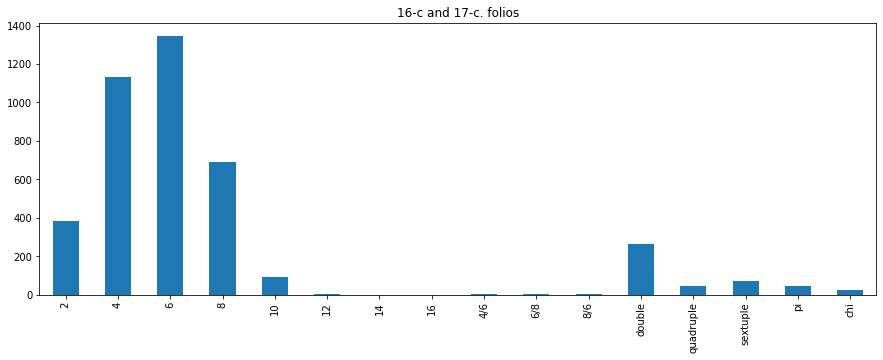

In [103]:
df_1516 = df.loc[pd.to_numeric(df['year1']).isin(range(1500,1699))]
df_1516_folio = df_1516.loc[df_1516['format'] == 'folio']
df_fifteenthsixteenth_folio = sum_and_dropzero(df_1516_folio, columns_quires)
display(df_fifteenthsixteenth_folio)
df_fifteenthsixteenth_folio.iloc[0].plot(kind='bar', title='16-c and 17-c. folios',figsize=(15,5))

Obviously the kind of datamining could serve well to further our understanding of quiring practices, which in the past could only rely on smallish data samples (if any). 

Furthermore, here we have only looked at the relation between the collation, bibliographic format, date of publication and place, yet the other metadata available for the corpus, such as printer, language, subject matter, etcetera, offer a plethora of additional possibilities for interpreting quiring patterns. Moreover, it is important to note that our algorithm only records whether an edition contains a certain quiring or not, whereas it does not count the amount of gatherings that use a certain quiring. Implementing this would not be trivial, but perhaps not impossible.

In short, we hope this data analysis may serve as an *invitation à la danse* for future book historical research into this topic.